# Lab 03 : Graph convolutional networks for classification - solution

Kipf, Welling, Semi-supervised classification with graph convolutional networks, 2016  
https://arxiv.org/pdf/1609.02907.pdf

### Xavier Bresson

<br>
Notebook goals :<br>  
• Add node features to DGL graphs  <br> 
• Create a DGL batch of graphs  <br> 
• Implement GCN message-passing function with DGL  <br> 
  

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/05_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL
    

In [2]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

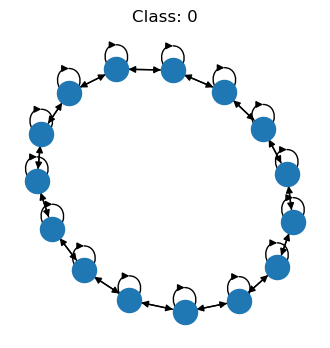

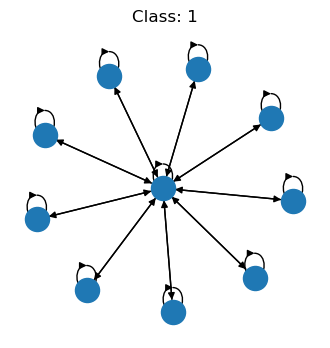

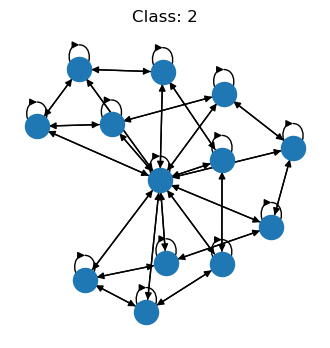

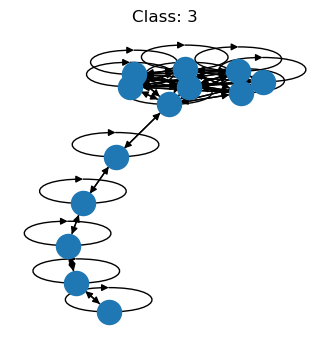

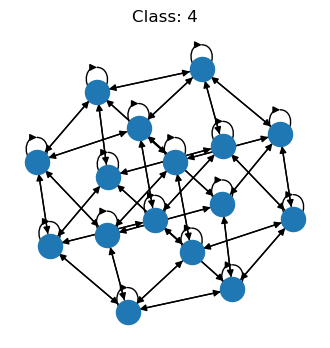

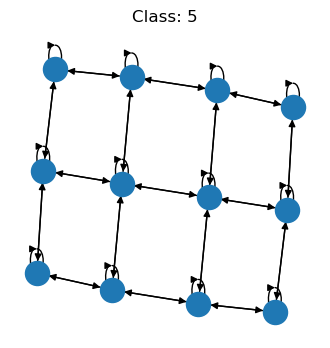

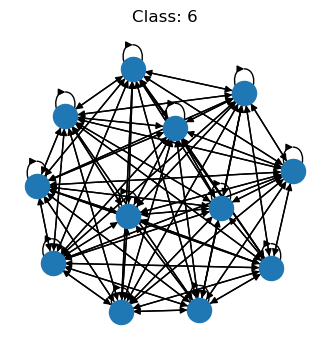

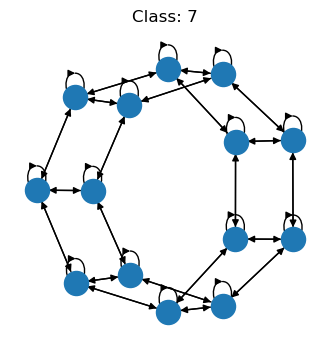

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node feature

In [8]:
# Add node features to graphs
def add_node_features(dataset):
    for (graph,_) in dataset:
        # node feature = node in-degree
        # graph.ndata['feat'].size()=(num_nodes,1) and graph.ndata['feat'].type()=torch.FloatTensor
        # you may use ".in_degrees(), .view(), .float()" 
        #graph.ndata['feat'] = ### YOUR CODE HERE
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feat is in-degree
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_features(trainset)
testset = add_node_features(testset)
valset = add_node_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [20]:
# collate function prepares a batch of graphs and labels 
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples)) # "graphs" is a list of "batch_size" DGL graphs
                                              # "labels" is a list of "batch_size" class labels
    # Create the DGL batch of graphs, which is equivalent to build a block diagonal matrix with all graphs in the batch
    # You may use DGL module "dgl.batch()" and print the result
    #batch_graphs = ### YOUR CODE HERE
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels
    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())


Graph(num_nodes=149, num_edges=637,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([0, 3, 5, 0, 7, 7, 4, 1, 2, 4])
batch_x: torch.Size([149, 1])


# Design the class of GCN networks with DGL

Node update equation:  
\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \left( \frac{1}{\sqrt{d_i}} \sum_{j\sim i} \frac{1}{\sqrt{d_j}} W^\ell h_j^{\ell} \right)
\end{eqnarray}

In [25]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GCN_layer, self).__init__()
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        # Pass the messages Wh_j and d_j (in-degree_j) to the node i
        # You may use ".src[]"
        #Whj = ### YOUR CODE HERE
        #dj = ### YOUR CODE HERE
        Whj = edges.src['Wh'] 
        dj = edges.src['d'] 
        return {'Whj' : Whj, 'dj' : dj}

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Whj, dj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        # You may use ".mailbox[]"
        #Whj = ### YOUR CODE HERE
        #dj = ### YOUR CODE HERE
        Whj = nodes.mailbox['Whj']
        dj = nodes.mailbox['dj']
        inv_sqrt_dj = torch.pow(dj, -0.5) # 1/sqrt(d_j)
        h = torch.sum( inv_sqrt_dj * Whj, dim=1 ) # hi = sum_j 1/sqrt(d_j) * Bhj 
        return {'h' : h} # return update node feature hi
    
    def forward(self, g, h):
        h_in = h # residual connection
        g.ndata['Wh'] = self.W(h) # linear transformation 
        d = g.in_degrees().view(-1, 1).float() # in-degree d_i
        g.ndata['d'] = d
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        h = g.ndata['h'] # collect the node output of graph convolution
        inv_sqrt_d = torch.pow(d, -0.5) # 1/ sqrt(d_i)
        h = inv_sqrt_d * h # h_i / sqrt(d_i)
        h = torch.relu(h) # non-linear activation
        h = h_in + h # residual connection
        return h
    
    
class GCN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GCN_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.GCN_layers = nn.ModuleList([ GCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # graph convnet layers
        for GCNlayer in self.GCN_layers:
            h = GCNlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GCN_net(net_parameters)
print(net)


GCN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GCN_layers): ModuleList(
    (0-3): 4 x GCN_layer(
      (W): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)


# Train the network

In [26]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train()
    else:
        net.eval()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GCN_net(net_parameters)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

/Users/xbresson/miniconda3/envs/gnn_course_apr23/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 0.5341, train_loss: 2.1550, test_loss: 2.0240, val_loss: 2.0240
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 0.4561, train_loss: 1.9822, test_loss: 1.9656, val_loss: 1.9656
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 0.5282, train_loss: 1.9412, test_loss: 1.9524, val_loss: 1.9524
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 3, time 0.6729, train_loss: 1.9224, test_loss: 1.9351, val_loss: 1.9351
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 4, time 0.7719, train_loss: 1.9099, test_loss: 1.9182, val_loss: 1.9182
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 5, time 0.5178, train_loss: 1.8935, test_loss: 1.9030, val_loss: 1.9030
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 6, time 0.6251, train_loss: 1.8820, test_loss: 1.8902, val_loss: 1.8902
    